In [1]:
import numpy as np
import sys
import os
import glob
import importlib
import math as m
import pickle as pickle
import seaborn as sns
import statistics
import pandas as pd
fmts = ['svg','pdf']
from scipy.stats import norm, wilcoxon, ttest_rel, friedmanchisquare, shapiro
from scipy import signal, fft
from scipy.optimize import curve_fit, minimize
import matplotlib # produce matlab-style plots
from matplotlib import animation as ani # animation
import matplotlib.pyplot as plt # Matlab-style plotting
from matplotlib import rcParams
matplotlib.rc('font',**{'size':20}) # increase font size on plots
matplotlib.rc('text',usetex=False) # use LaTeX to render symbols
matplotlib.rc('animation',html='html5') # render animation
font = {#'family' : 'normal',
        'weight' : 'ultralight',
        'size'   : 14}
matplotlib.rc('font', **font)
rcParams['axes.titlesize'] = 16
rcParams['font.weight'] = 'ultralight'
rcParams['font.family'] = 'sans-serif'
rcParams['mathtext.fontset'] = 'cm'
prop_cycle = plt.rcParams['axes.prop_cycle']
python_colors = prop_cycle.by_key()['color'] # python default color cycle

# auto reload modules
%load_ext autoreload
%autoreload 2
sys.path.append('C:\\Users\\amber\\Documents\\GitHub\\sensorimotor_fusion\\analysis\\Multimodal paper') # change this for your computer
from globalVars import *
from collect_data import findFilename, getrawdata, get_data, analyze
from analysis import *
# DATA_PATH = 'C:\\Users\\amber\\Documents\\GitHub\\sensorimotor_fusion' #change this for your computer

In [2]:
from globalVars import *
from collect_data import findFilename, getrawdata, get_data, analyze
from analysis import *

In [3]:
print('data length = ',N)
print('primes = ',primes)
print('base freq = ',base_freq)
print('IX = ',IX)
print('Even_IX = ',Even_IX)
print('Odd_IX = ',Odd_IX)
print('freqs = ',freqs)
print('omegas = ',omegas)
print('T = ',T) # total time 40 seconds
print('t = ',t) # timestamps
print('fs = ',fs)
print('sample_period (dt)= ',dt)
print('xf = ',xf) # frequency domain x-axis, shape (N//2,)
print('Machine = ',M) # soM at stimulated freqs
print('scaleInput = ',scaleInput)
print('scaleOutputScreen = ',scaleOutputScreen)

data length =  2400
primes =  [ 2  3  5  7 11 13 17 19]
base freq =  0.05
IX =  [ 4  6 10 14 22 26 34 38]
Even_IX =  [ 6 14 26 38]
Odd_IX =  [ 4 10 22 34]
freqs =  [0.1  0.15 0.25 0.35 0.55 0.65 0.85 0.95]
omegas =  [0.62831853 0.9424778  1.57079633 2.19911486 3.45575192 4.08407045
 5.34070751 5.96902604]
T =  40
t =  [0.00000000e+00 1.66736140e-02 3.33472280e-02 ... 3.99666528e+01
 3.99833264e+01 4.00000000e+01]
fs =  60
sample_period (dt)=  0.016666666666666666
xf =  [0.0000e+00 2.5000e-02 5.0000e-02 ... 2.9925e+01 2.9950e+01 2.9975e+01]
Machine =  [-0.7169568 -1.14107219j -0.52958685-0.5619091j  -0.28840044-0.18360142j
 -0.17134712-0.0779164j  -0.07726649-0.02235881j -0.05656227-0.01384948j
 -0.03387172-0.00634218j -0.02730057-0.00457371j]
scaleInput =  0.04616974606700115
scaleOutputScreen =  0.25


# Load data

In [24]:
# with open('multimodal_data.pkl', 'wb') as file:
#     pickle.dump(ALLdata, file)

# Load the array from the file
with open('multimodal_data.pkl', 'rb') as file:
    Rs,Ds,Us,U0s,U1s,Ys,rs,ds,us,u0s,u1s,ys,errors,Tur,Tu0r,Tu1r,Tud,Tu0d,Tu1d,Tyr,Tyd = pickle.load(file)

In [25]:
print(Rs.shape) # subject x condition x trial x all freqs
print(rs.shape) # subject x condition x trial x timestamps
print(errors.shape) # subject x condition x trial

subject_num = Rs.shape[0]
condition_num = Rs.shape[1]
trial_num = Rs.shape[2]
print('subject_num = ',subject_num)
print('condition_num (alphas) = ',condition_num)
print('trial_num = ',trial_num)
alphas = np.array([0,0.25,0.5,0.75,1])
conditions = ['0','0.25','0.5','0.75','1']

(15, 5, 14, 2400)
(15, 5, 14, 2400)
(15, 5, 14)
subject_num =  15
condition_num (alphas) =  5
trial_num =  14


# Time Domain

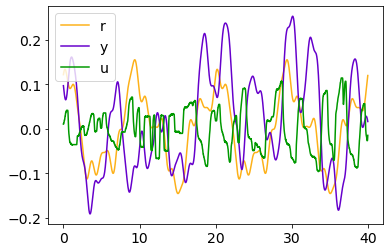

In [23]:
# example trial
plt.plot(t,rs[0,0,-1,:],label = 'r',color = colors['r'])
plt.plot(t,ys[0,0,-1,:],label = 'y',color = colors['y'])
plt.plot(t,us[0,0,-1,:],label = 'u',color = colors['u'])
plt.legend()
plt.show()

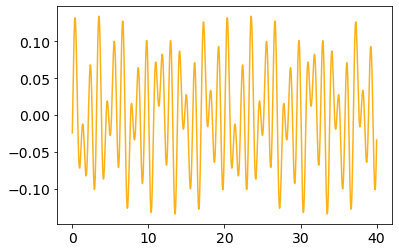

In [123]:
plt.plot(t,ds[0,0,-1,:],label = 'r',color = colors['r'])

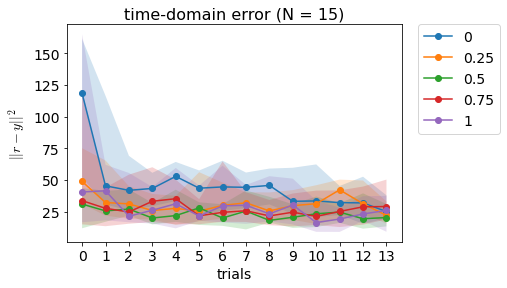

In [7]:
fig,ax = plt.subplots(sharex=True,figsize=(6,4))
x = np.arange(0,trial_num,1)
for iC, condition in enumerate(conditions):
    mean, quantile25, quantile50, quantile75 = mean_and_interquartile(errors[:,iC,:], axis = 0)
    ax.plot(x, quantile50,'-o',label = condition)
    ax.fill_between(x, quantile25, quantile75, alpha=0.2)
ax.set_xticks(x)
ax.set_title('time-domain error (N = 15)')
ax.set_xlabel('trials')
ax.set_ylabel(r'$||r-y||^2$')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

## performance of each subjects

In [341]:
errors.shape

(15, 5, 14)

In [346]:
# which subjects did the best for each condition?
np.argmin(np.mean(errors,axis = 2),axis = 0) #HCPS107, 106, 109

array([6, 5, 5, 8, 8], dtype=int64)

# Human model H

In [8]:
Hs = -Us / Ys  #-inp/out
Hs.shape

(15, 5, 14, 2400)

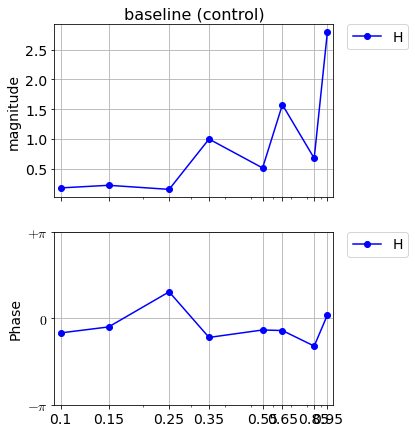

In [9]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (-np.pi,np.pi)
yticksphase = [-np.pi,0.,np.pi]
yticklabelsphase = [r'$-\pi$',r'$0$',r'$+\pi$']
sub = 0
cond = 0
trial = 0

fig,axs = plt.subplots(2,1,sharex=True,figsize=(5,7))
ax = axs[0]
ax.plot(freqs,np.abs(Hs[sub,cond,trial,IX]),'-o',color= 'blue',label = 'H')
ax.set_xscale("log")
ax.set_xlim(xlim)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,rotation=90) 
ax.grid('on',zorder=-1)
ax.set_ylabel('magnitude')
ax.set_title('baseline (control)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

ax = axs[1]
ax.plot(freqs,np.angle(Hs[sub,cond,trial,IX]),'-o',color= 'blue',label = 'H')
ax.set_ylabel('Phase') 
ax.grid('on',zorder=-1)
ax.set_ylim(ylimphase)
ax.set_yticks(yticksphase)
ax.set_yticklabels(yticklabelsphase)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

# FF and FB

In [26]:
def FF_FB(Tur,Tud):
    B = - (1 / M) * (Tud / (1+ Tud)) 
    F = (1 + B * M)*Tur - B
    return F,B

In [27]:
F = np.zeros(Tur.shape, dtype=complex) #number of stimulated freqs = 8
B = np.zeros(Tur.shape, dtype=complex)
for sub in range(subject_num):
    for cond in range(condition_num):
        for i in range(trial_num//2):
            F[sub,cond,i],B[sub,cond,i] = FF_FB(Tur[sub,cond,i],Tud[sub,cond,i])
print(F.shape) # subject x condition x trial//2 x stimulated freqs
print(B.shape)

(15, 5, 7, 8)
(15, 5, 7, 8)


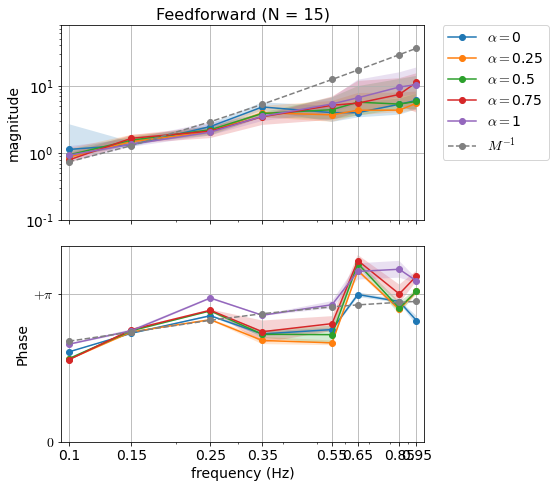

In [52]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (0, np.pi+1)
yticksphase = [0.,np.pi]
yticklabelsphase = [r'$0$',r'$+\pi$']

fig,axs = plt.subplots(2,1,sharex=True,figsize=(8,7))
for cond in range(condition_num):
    F_mean = np.mean(np.abs(F[:,cond,:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0]
    ax.plot(freqs,q50,'-o',label = r'$\alpha = $'+conditions[cond])
    ax.fill_between(freqs, q25, q75, alpha=0.2)
    # phase
    ax = axs[1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F[:,cond,:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-o',label = r'$\alpha = $'+conditions[cond])
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2)

ax = axs[0]
ax.plot(freqs,np.abs(1/M),'--o',color= 'grey',label = r'$M^{-1}$')
ax.set_xscale("log")
ax.set_xlim(xlim)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,rotation=90) 
ax.grid('on',zorder=-1)
ax.set_ylim(0.1,80)
ax.set_yscale("log")
ax.set_ylabel('magnitude')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

ax = axs[1]
ax.plot(freqs,np.angle(1/M),'--o',color= 'grey',label = r'$M^{-1}$')
ax.set_ylabel('Phase') 
ax.grid('on',zorder=-1)
ax.set_ylim(ylimphase)
ax.set_yticks(yticksphase)
ax.set_yticklabels(yticklabelsphase)
ax.set_xlabel('frequency (Hz)')
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
axs[0].set_title('Feedforward (N = 15)')
plt.tight_layout()
plt.show()

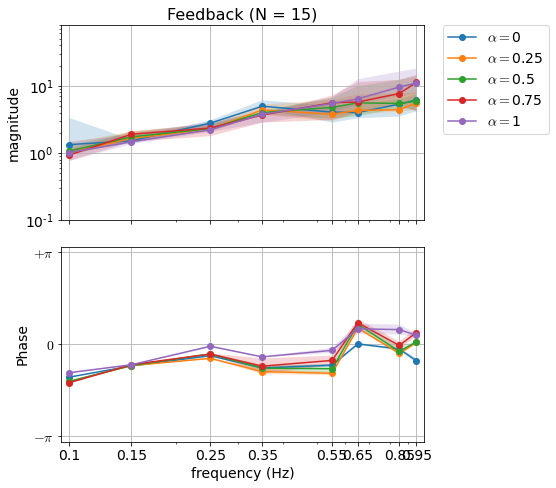

In [56]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (-np.pi-0.2,np.pi+ 0.2)
yticksphase = [-np.pi,0.,np.pi]
yticklabelsphase = [r'$-\pi$',r'$0$',r'$+\pi$']

fig,axs = plt.subplots(2,1,sharex=True,figsize=(8,7))
for cond in range(condition_num):
    F_mean = np.mean(np.abs(B[:,cond,:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0]
    ax.plot(freqs,q50,'-o',label = r'$\alpha = $'+conditions[cond])
    ax.fill_between(freqs, q25, q75, alpha=0.2)
    # phase
    ax = axs[1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(B[:,cond,:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-o',label = r'$\alpha = $'+conditions[cond])
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2)

ax = axs[0]
# ax.plot(freqs,np.abs(1/M),'--o',color= 'grey',label = r'$M^{-1}$')
ax.set_xscale("log")
ax.set_xlim(xlim)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,rotation=90) 
ax.grid('on',zorder=-1)
ax.set_ylim(0.1,80)
ax.set_yscale("log")
ax.set_ylabel('magnitude')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

ax = axs[1]
# ax.plot(freqs,np.angle(1/M),'--o',color= 'grey',label = r'$M^{-1}$')
ax.set_ylabel('Phase') 
ax.grid('on',zorder=-1)
ax.set_ylim(ylimphase)
ax.set_yticks(yticksphase)
ax.set_yticklabels(yticklabelsphase)
ax.set_xlabel('frequency (Hz)')
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
axs[0].set_title('Feedback (N = 15)')
plt.tight_layout()
plt.show()

# FF_Slider and FF_EMG

In [57]:
def FF_FB_each_modality(Tu0r,Tu0d,Tu1r,Tu1d,w): #w = weighting of EMG
    w0 = w
    w1 = 1-w
    B0 = (- (1/M) * Tu0d) / (1 + w0*Tu0d + w1*Tu1d)
    B1 = (- (1/M) * Tu1d) / (1 + w0*Tu0d + w1*Tu1d)
    F0 = -B0 + Tu0r + w0 * B0 * M * Tu0r + w1 * B0 * M * Tu1r
    F1 = -B1 + Tu1r + w0 * B1 * M * Tu0r + w1 * B1 * M * Tu1r
    return F0,F1,B0,B1

In [169]:
F0 = np.zeros(Tur.shape, dtype=complex) #number of stimulated freqs = 8
F1 = np.zeros(Tur.shape, dtype=complex) #number of stimulated freqs = 8
B0 = np.zeros(Tur.shape, dtype=complex)
B1 = np.zeros(Tur.shape, dtype=complex)
for sub in range(subject_num):
    for cond in range(condition_num):
        w = alphas[cond]
        for i in range(trial_num//2):
            F0[sub,cond,i],F1[sub,cond,i],B0[sub,cond,i],B1[sub,cond,i] \
                = FF_FB_each_modality(Tu0r[sub,cond,i],Tu0d[sub,cond,i],Tu1r[sub,cond,i],Tu1d[sub,cond,i],w)
print(F0.shape) # subject x condition x trial//2 x stimulated freqs
print(B0.shape)

(15, 5, 7, 8)
(15, 5, 7, 8)


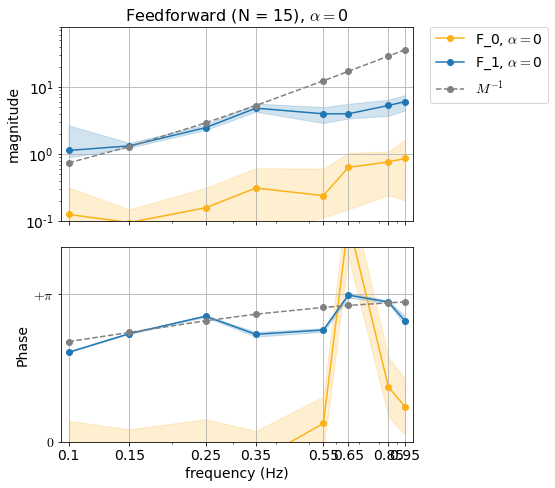

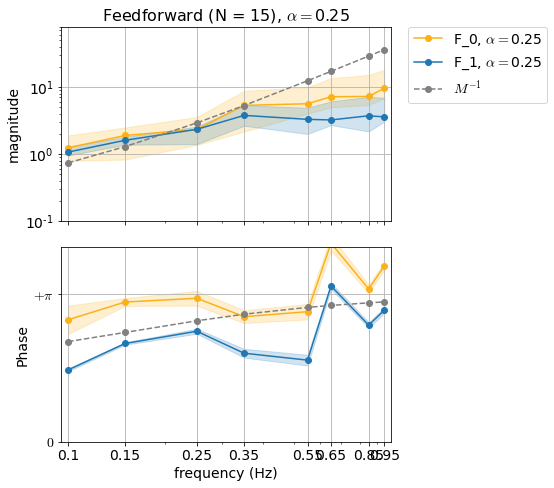

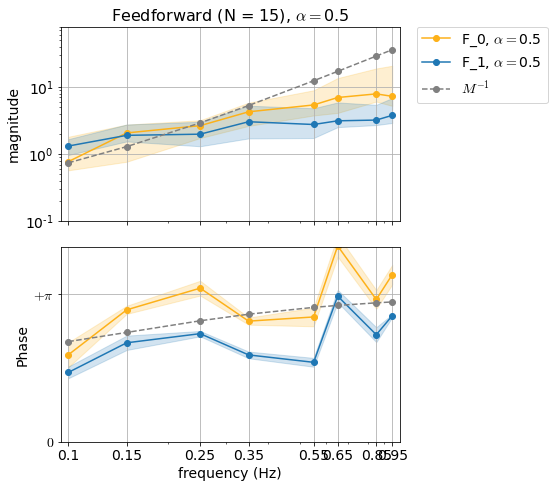

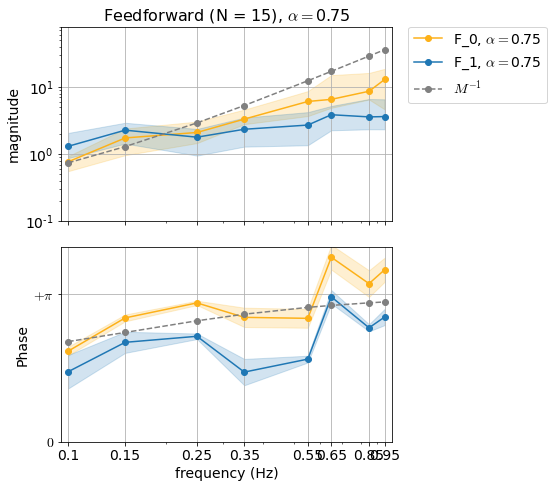

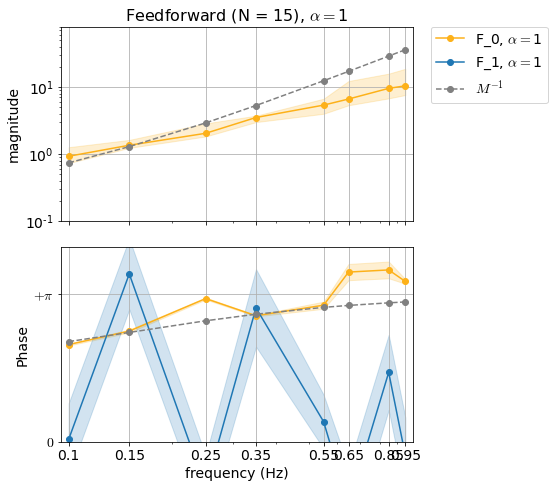

In [173]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (0, np.pi+1)
yticksphase = [0.,np.pi]
yticklabelsphase = [r'$0$',r'$+\pi$']

for cond in range(condition_num):
    fig,axs = plt.subplots(2,1,sharex=True,figsize=(8,7))

    # F0
    F_mean = np.mean(np.abs(F0[:,cond,:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0]
    ax.plot(freqs,q50,'-o',label = r'F_0, $\alpha = $'+conditions[cond],color = colors['GOLD'])
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['GOLD'])
    # phase
    ax = axs[1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F0[:,cond,:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-o',label = r'$\alpha = $'+conditions[cond],color = colors['GOLD'])
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GOLD'])

    # F1
    F_mean = np.mean(np.abs(F1[:,cond,:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0]
    ax.plot(freqs,q50,'-o',label = r'F_1, $\alpha = $'+conditions[cond],color = colors['BLUE'])
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['BLUE'])
    # phase
    ax = axs[1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(F1[:,cond,:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-o',label = r'$\alpha = $'+conditions[cond],color = colors['BLUE'])
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['BLUE'])

    ax = axs[0]
    ax.plot(freqs,np.abs(1/M),'--o',color= 'grey',label = r'$M^{-1}$')
    ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks,rotation=90) 
    ax.grid('on',zorder=-1)
    ax.set_ylim(0.1,80)
    ax.set_yscale("log")
    ax.set_ylabel('magnitude')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    ax = axs[1]
    ax.plot(freqs,np.angle(1/M),'--o',color= 'grey',label = r'$M^{-1}$')
    ax.set_ylabel('Phase') 
    ax.grid('on',zorder=-1)
    ax.set_ylim(ylimphase)
    ax.set_yticks(yticksphase)
    ax.set_yticklabels(yticklabelsphase)
    ax.set_xlabel('frequency (Hz)')
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    axs[0].set_title(r'Feedforward (N = 15), $\alpha = $'+conditions[cond])
    plt.tight_layout()
    plt.show()

# FB_Slider and FB_EMG

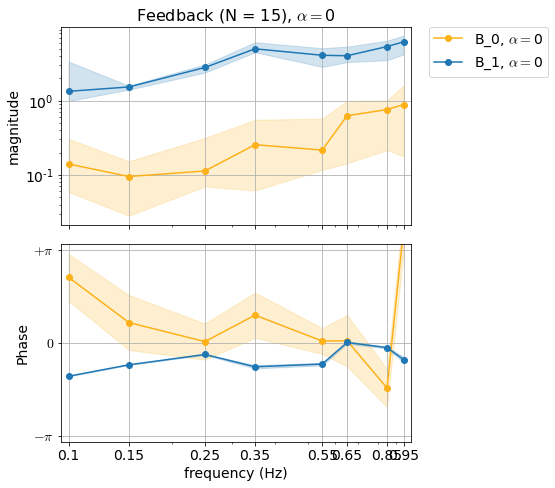

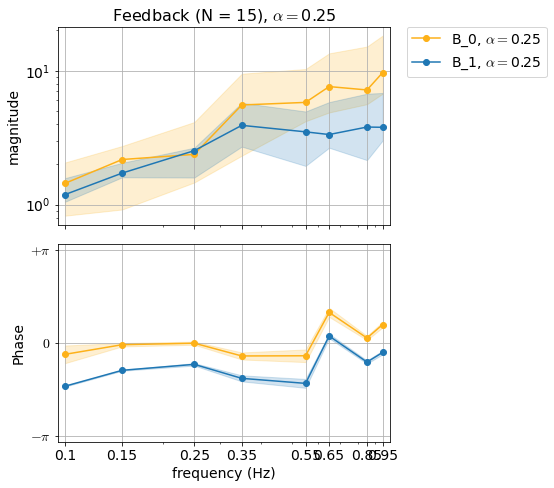

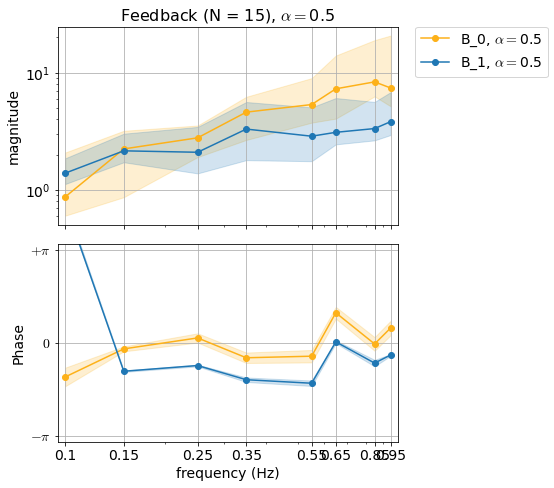

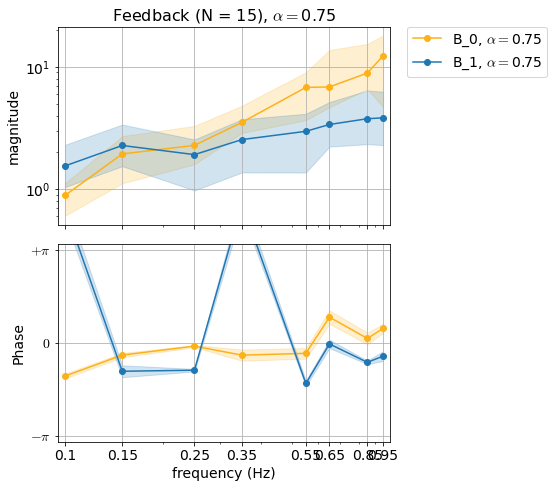

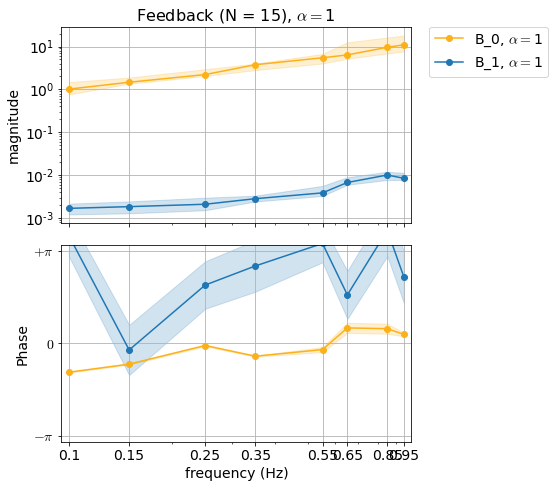

In [172]:
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (-np.pi-0.2,np.pi+ 0.2)
yticksphase = [-np.pi,0.,np.pi]
yticklabelsphase = [r'$-\pi$',r'$0$',r'$+\pi$']


for cond in range(condition_num):
    fig,axs = plt.subplots(2,1,sharex=True,figsize=(8,7))

    # F0
    F_mean = np.mean(np.abs(B0[:,cond,:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0]
    ax.plot(freqs,q50,'-o',label = r'B_0, $\alpha = $'+conditions[cond],color = colors['GOLD'])
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['GOLD'])
    # phase
    ax = axs[1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(B0[:,cond,:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-o',label = r'$\alpha = $'+conditions[cond],color = colors['GOLD'])
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GOLD'])

    # F1
    F_mean = np.mean(np.abs(B1[:,cond,:,:]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(F_mean,[0.25,0.5,0.75],axis = 0)
    # magnitude
    ax = axs[0]
    ax.plot(freqs,q50,'-o',label = r'B_1, $\alpha = $'+conditions[cond],color = colors['BLUE'])
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['BLUE'])
    # phase
    ax = axs[1]
    F_angle = np.angle(np.mean(np.exp(1j*(np.angle(B1[:,cond,:,:]))),axis = 1))
    z = np.mean(np.exp(1j*(F_angle-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-o',label = r'$\alpha = $'+conditions[cond],color = colors['BLUE'])
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['BLUE'])

    ax = axs[0]
    # ax.plot(freqs,np.abs(1/M),'--o',color= 'grey',label = r'$M^{-1}$')
    ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks,rotation=90) 
    ax.grid('on',zorder=-1)
    # ax.set_ylim(0.1,80)
    ax.set_yscale("log")
    ax.set_ylabel('magnitude')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    ax = axs[1]
    # ax.plot(freqs,np.angle(1/M),'--o',color= 'grey',label = r'$M^{-1}$')
    ax.set_ylabel('Phase') 
    ax.grid('on',zorder=-1)
    ax.set_ylim(ylimphase)
    ax.set_yticks(yticksphase)
    ax.set_yticklabels(yticklabelsphase)
    ax.set_xlabel('frequency (Hz)')
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    axs[0].set_title(r'Feedback (N = 15), $\alpha = $'+conditions[cond])
    plt.tight_layout()
    plt.show()

# user effort of the two modalities

## individual

In [333]:
sub = 5
cond = 2
trial = -5

In [334]:
trial_error = rs[sub,cond,trial,:]-ys[sub,cond,trial,:]
E = np.fft.fft(trial_error)/N

r_future = np.zeros_like(rs[sub,cond,trial,:]) 
r_future[:-30] = rs[sub,cond,trial,30:] # 0.5sec *60 Hz 
r_future

array([0.08794698853561075, 0.08645560670773483, 0.08490857323281768, ...,
       0, 0, 0], dtype=object)

In [335]:
r_dev = derivative(t,rs[sub,cond,trial,:])
r_acc = double_derivative(t,rs[sub,cond,trial,:])

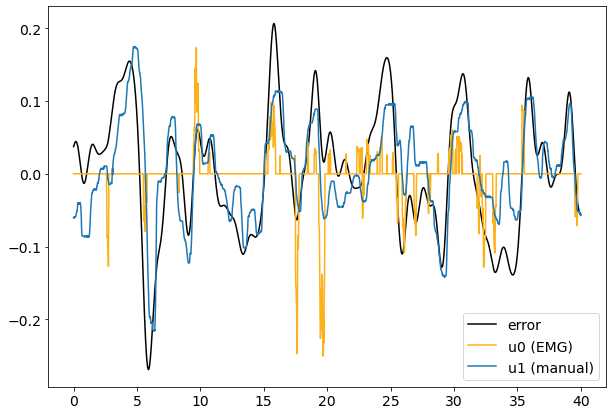

In [336]:
fig,ax = plt.subplots(sharex=True,figsize=(10,7))
ax.plot(t,rs[sub,cond,trial,:]-ys[sub,cond,trial,:],label = 'error',color = 'black')
# ax.plot(t,r_future-ys[sub,cond,trial,:],label = 'error, future',color = 'black')
# ax.plot(t,rs[sub,cond,trial,:],label = 'r',color = 'red')
# ax.plot(t,ys[sub,cond,trial,:],label = 'y',color = 'purple')
ax.plot(t,u0s[sub,cond,trial,:],label = 'u0 (EMG)',color = colors['GOLD'])
ax.plot(t,u1s[sub,cond,trial,:],label = 'u1 (manual)',color = colors['BLUE'])
ax.legend()
plt.show()

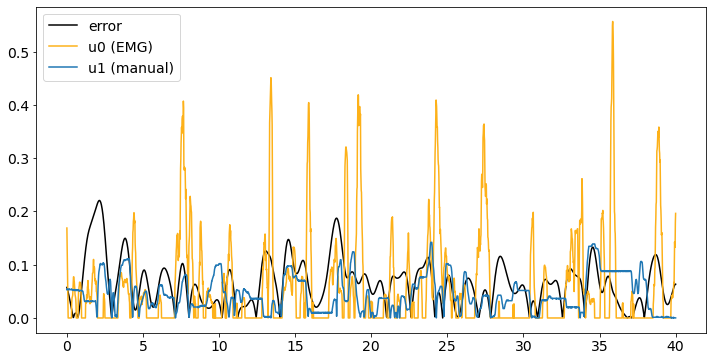

In [328]:
fig,ax = plt.subplots(sharex=True,figsize=(12,6))
ax.plot(t,np.abs(rs[sub,cond,trial,:]-ys[sub,cond,trial,:]),label = 'error',color = 'black')
# ax.plot(t,r_future-ys[sub,cond,trial,:],label = 'error, future',color = 'black')
# ax.plot(t,rs[sub,cond,trial,:],label = 'r',color = 'red')
# ax.plot(t,ys[sub,cond,trial,:],label = 'y',color = 'purple')
ax.plot(t,np.abs(u0s[sub,cond,trial,:]),label = 'u0 (EMG)',color = colors['GOLD'])
ax.plot(t,np.abs(u1s[sub,cond,trial,:]),label = 'u1 (manual)',color = colors['BLUE'])
ax.legend()
plt.show()

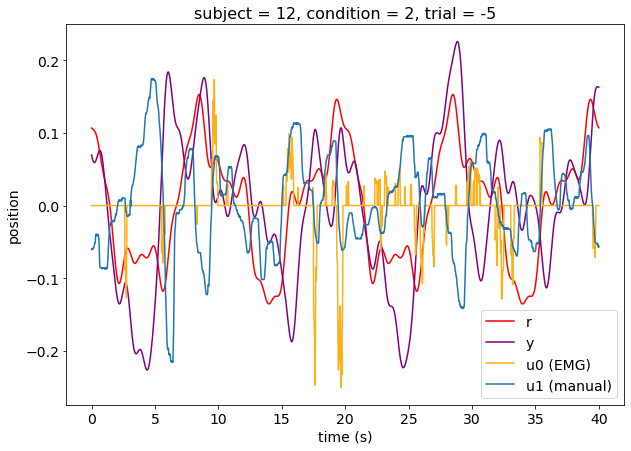

In [337]:
fig,ax = plt.subplots(sharex=True,figsize=(10,7))

# ax.plot(t,rs[sub,cond,trial,:]-ys[sub,cond,trial,:],label = 'error',color = 'black')
ax.plot(t,rs[sub,cond,trial,:],label = 'r',color = 'red')
# ax.plot(t,r_dev,label = 'r_dev',color = 'black')
ax.plot(t,ys[sub,cond,trial,:],label = 'y',color = 'purple')
ax.plot(t,u0s[sub,cond,trial,:],label = 'u0 (EMG)',color = colors['GOLD'])
ax.plot(t,u1s[sub,cond,trial,:],label = 'u1 (manual)',color = colors['BLUE'])
ax.legend()
ax.set_ylabel('position')
ax.set_xlabel('time (s)')
ax.set_title('subject = '+str(sub)+', condition = '+str(cond)+', trial = '+str(trial))
plt.show()

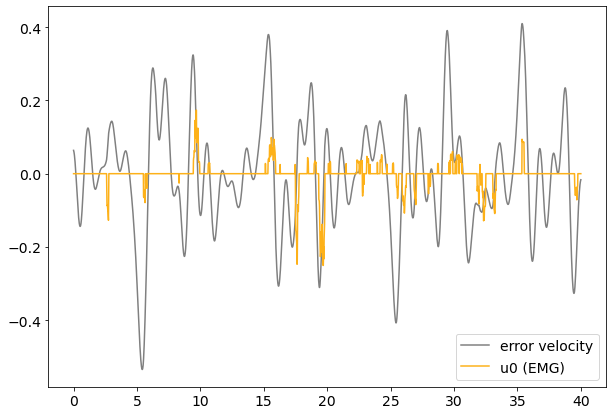

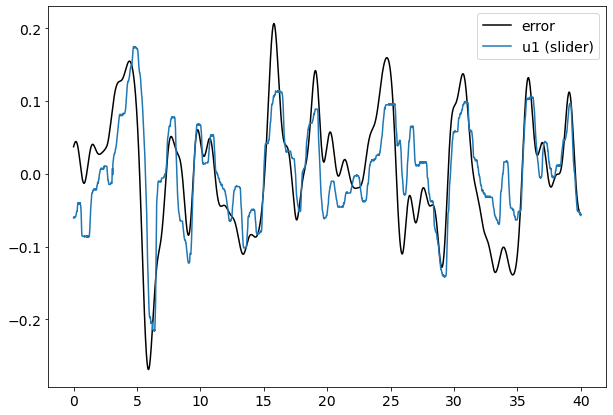

In [338]:
# inputs and the speed of error 

fig,ax = plt.subplots(sharex=True,figsize=(10,7))

vel = derivative(t, trial_error)
acc = double_derivative(t, trial_error)
acc = double_derivative(t, trial_error)

# ax.plot(t,trial_error,label = 'error',color = 'black')
ax.plot(t,vel,label = 'error velocity',color = 'grey')
# ax.plot(t,acc*0.5,label = 'error acceleration',color = 'grey')
ax.plot(t,u0s[sub,cond,trial,:],label = 'u0 (EMG)',color = colors['GOLD'])
# ax.plot(t,u1s[sub,cond,trial,:],label = 'u1 (slider)',color = colors['BLUE'])
ax.legend()
plt.show()

fig,ax = plt.subplots(sharex=True,figsize=(10,7))
# ax.plot(t,rs[sub,cond,trial,:],label = 'r',color = 'red')
ax.plot(t,trial_error,label = 'error',color = 'black')
# ax.plot(t,u0s[sub,cond,trial,:],label = 'u0 (EMG)',color = colors['GOLD'])
ax.plot(t,u1s[sub,cond,trial,:],label = 'u1 (slider)',color = colors['BLUE'])
ax.legend()
plt.show()


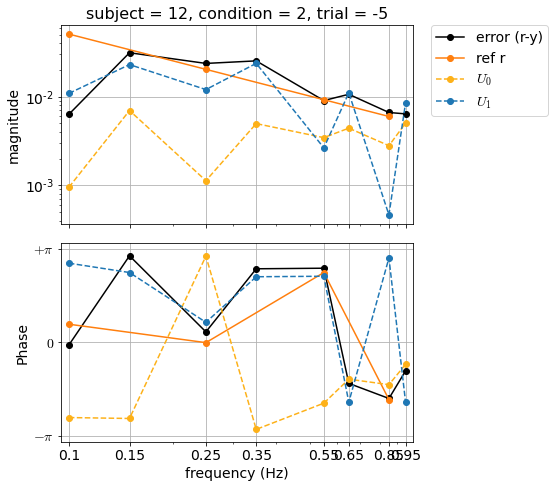

In [348]:


# freq plot for errors and inputs
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (-np.pi-0.2,np.pi+ 0.2)
yticksphase = [-np.pi,0.,np.pi]
yticklabelsphase = [r'$-\pi$',r'$0$',r'$+\pi$']

fig,axs = plt.subplots(2,1,sharex=True,figsize=(8,7))

# magnitude
ax = axs[0]
ax.plot(freqs,np.abs(E[IX]),'-o',label = 'error (r-y)',color = 'black')
ax.plot(freqs[::2],np.abs(Rs[sub,cond,trial,IX[::2]]),'-o',label = 'ref r',color = python_colors[1])
# ax.plot(freqs[1::2],np.abs(Ds[sub,cond,trial,IX[1::2]]),'-o',label = 'dis',color = python_colors[2])
ax.plot(freqs,np.abs(U0s[sub,cond,trial,IX]),'--o',color= colors['GOLD'],label = r'$U_0$')
ax.plot(freqs,np.abs(U1s[sub,cond,trial,IX]),'--o',color= colors['BLUE'],label = r'$U_1$')
# ax.plot(freqs,np.abs(1/M),'--o',color= 'grey',label = r'$M^{-1}$')
ax.set_xscale("log")
ax.set_xlim(xlim)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,rotation=90) 
ax.grid('on',zorder=-1)
# ax.set_ylim(0.1,80)
ax.set_yscale("log")
ax.set_ylabel('magnitude')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# phase
ax = axs[1]
ax.plot(freqs,np.angle(E[IX]),'-o',label = 'error',color = 'black')
ax.plot(freqs[::2],np.angle(Rs[sub,cond,trial,IX[::2]]),'-o',label = 'ref r',color = python_colors[1])
ax.plot(freqs,np.angle(U0s[sub,cond,trial,IX]),'--o',color= colors['GOLD'],label = r'$U_0$')
ax.plot(freqs,np.angle(U1s[sub,cond,trial,IX]),'--o',color= colors['BLUE'],label = r'$U_1$')
ax.set_ylabel('Phase') 
ax.grid('on',zorder=-1)
ax.set_ylim(ylimphase)
ax.set_yticks(yticksphase)
ax.set_yticklabels(yticklabelsphase)
ax.set_xlabel('frequency (Hz)')
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
axs[0].set_title('subject = '+str(sub)+', condition = '+str(cond)+', trial = '+str(trial))
plt.tight_layout()
plt.show()

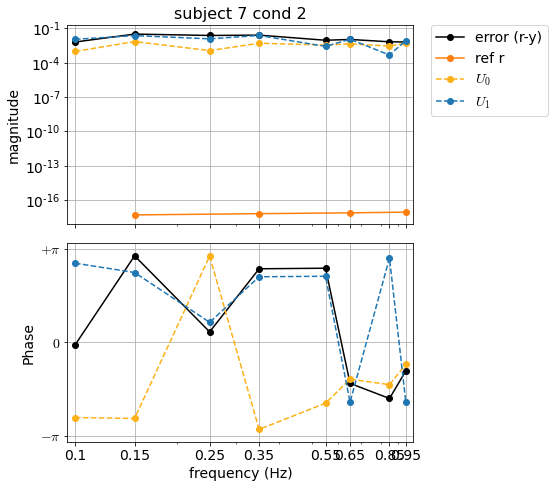

In [340]:
# freq plot for errors and inputs
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (-np.pi-0.2,np.pi+ 0.2)
yticksphase = [-np.pi,0.,np.pi]
yticklabelsphase = [r'$-\pi$',r'$0$',r'$+\pi$']

fig,axs = plt.subplots(2,1,sharex=True,figsize=(8,7))

# magnitude
ax = axs[0]
ax.plot(freqs,np.abs(E[IX]),'-o',label = 'error (r-y)',color = 'black')
ax.plot(freqs[1::2],np.abs(Rs[sub,cond,trial,IX[1::2]]),'-o',label = 'ref r',color = python_colors[1])
# ax.plot(freqs[1::2],np.abs(Ds[sub,cond,trial,IX[1::2]]),'-o',label = 'dis',color = python_colors[2])
ax.plot(freqs,np.abs(U0s[sub,cond,trial,IX]),'--o',color= colors['GOLD'],label = r'$U_0$')
ax.plot(freqs,np.abs(U1s[sub,cond,trial,IX]),'--o',color= colors['BLUE'],label = r'$U_1$')
# ax.plot(freqs,np.abs(1/M),'--o',color= 'grey',label = r'$M^{-1}$')
ax.set_xscale("log")
ax.set_xlim(xlim)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,rotation=90) 
ax.grid('on',zorder=-1)
# ax.set_ylim(0.1,80)
ax.set_yscale("log")
ax.set_ylabel('magnitude')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# phase
ax = axs[1]
ax.plot(freqs,np.angle(E[IX]),'-o',label = 'error',color = 'black')
ax.plot(freqs,np.angle(U0s[sub,cond,trial,IX]),'--o',color= colors['GOLD'],label = r'$U_0$')
ax.plot(freqs,np.angle(U1s[sub,cond,trial,IX]),'--o',color= colors['BLUE'],label = r'$U_1$')
ax.set_ylabel('Phase') 
ax.grid('on',zorder=-1)
ax.set_ylim(ylimphase)
ax.set_yticks(yticksphase)
ax.set_yticklabels(yticklabelsphase)
ax.set_xlabel('frequency (Hz)')
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
axs[0].set_title('subject 7 cond 2')
plt.tight_layout()
plt.show()

In [ ]:
feefforward_error = rs[sub,cond,trial,:]-ys[sub,cond,trial,:] #0.5s preview window
FE = np.fft.fft(trial_error)/N

In [ ]:
# freq plot for errors and inputs
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (-np.pi-0.2,np.pi+ 0.2)
yticksphase = [-np.pi,0.,np.pi]
yticklabelsphase = [r'$-\pi$',r'$0$',r'$+\pi$']

fig,axs = plt.subplots(2,1,sharex=True,figsize=(8,7))

# magnitude
ax = axs[0]
ax.plot(freqs,np.abs(E[IX]),'-o',label = 'error',color = 'black')
# ax.plot(freqs[::2],np.abs(Rs[sub,cond,trial,IX[::2]]),'-o',label = 'ref',color = python_colors[1])
# ax.plot(freqs[1::2],np.abs(Ds[sub,cond,trial,IX[1::2]]),'-o',label = 'dis',color = python_colors[2])
ax.plot(freqs,np.abs(U0s[sub,cond,trial,IX]),'--o',color= colors['GOLD'],label = r'$U_0$')
ax.plot(freqs,np.abs(U1s[sub,cond,trial,IX]),'--o',color= colors['BLUE'],label = r'$U_1$')
# ax.plot(freqs,np.abs(1/M),'--o',color= 'grey',label = r'$M^{-1}$')
ax.set_xscale("log")
ax.set_xlim(xlim)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,rotation=90) 
ax.grid('on',zorder=-1)
# ax.set_ylim(0.1,80)
ax.set_yscale("log")
ax.set_ylabel('magnitude')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# phase
ax = axs[1]
ax.plot(freqs,np.angle(E[IX]),'-o',label = 'error',color = 'black')
ax.plot(freqs,np.angle(U0s[sub,cond,trial,IX]),'--o',color= colors['GOLD'],label = r'$U_0$')
ax.plot(freqs,np.angle(U1s[sub,cond,trial,IX]),'--o',color= colors['BLUE'],label = r'$U_1$')
ax.set_ylabel('Phase') 
ax.grid('on',zorder=-1)
ax.set_ylim(ylimphase)
ax.set_yticks(yticksphase)
ax.set_yticklabels(yticklabelsphase)
ax.set_xlabel('frequency (Hz)')
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
axs[0].set_title('subject 6 cond 2')
plt.tight_layout()
plt.show()

## inputs vs. errors

In [380]:
# Initialize an empty list to store arrays
result = []

# Example arrays with different lengths
arrays = [np.array([1, 2, 3]), np.array([4, 5]), np.array([6])]

# Append arrays in a loop
for arr in arrays:
    result.append(arr)

# Result is a list of arrays
print("List of arrays:", result)

# If you want to keep it as a NumPy array of dtype=object
result_as_array = np.array(result, dtype=object)
print("NumPy array with different lengths:", result_as_array)

List of arrays: [array([1, 2, 3]), array([4, 5]), array([6])]
NumPy array with different lengths: [array([1, 2, 3]) array([4, 5]) array([6])]


In [389]:
# u0 and u1 magnitudes when error is high vs low
trial_errors = rs-ys
high_errors_u0 = []
low_errors_u0 = []
high_errors_u1 = []
low_errors_u1 = []
for sub in range(subject_num):
    for cond in range(condition_num):
        for trial in range(trial_num):
            u0 = u0s[sub,cond,trial,:]
            u1 = u1s[sub,cond,trial,:]
            indices = np.where(np.abs(trial_errors[sub, cond, trial, :]) >= 0.08)
            high_errors_u0.append(np.abs(u0[indices]))
            high_errors_u1.append(np.abs(u1[indices]))
            indices = np.where(np.abs(trial_errors[sub, cond, trial, :]) < 0.08)
            low_errors_u0.append(np.abs(u0[indices]))
            low_errors_u1.append(np.abs(u1[indices]))
high_errors_u0 = np.concatenate(np.array(high_errors_u0))
low_errors_u0 = np.concatenate(np.array(low_errors_u0))
high_errors_u1 = np.concatenate(np.array(high_errors_u1))
low_errors_u1 = np.concatenate(np.array(low_errors_u1))

In [390]:
np.mean(high_errors_u0), np.mean(low_errors_u0), np.mean(high_errors_u1), np.mean(low_errors_u1)

(0.07693090302205946,
 0.06319722299016721,
 0.07249839712604146,
 0.0573817632227851)

## population

In [279]:
# rs_future = np.zeros_like(rs)
# rs_future[:,:,:,:-30] = rs[:,:,:,30:]
trial_errors = rs-ys
Es = np.fft.fft(trial_errors)/N

In [ ]:
error_velocities = np.zeros_like(rs)
error_accelerations = np.zeros_like(rs)

for sub in range(subject_num):
    for cond in range(condition_num):
        for trial in range(trial_num):
            trial_error = rs[sub,cond,trial,:]-ys[sub,cond,trial,:]
            vel = derivative(t, trial_error)
            acc = double_derivative(t, trial_error)
            error_velocities[sub,cond,trial,:] = vel
            error_accelerations[sub,cond,trial,:] = acc
E_ACCs = np.fft.fft(error_accelerations)/N
print(Es.shape)
print(error_velocities.shape)
print(error_accelerations.shape)

(15, 5, 14, 2400)
(15, 5, 14, 2400)
(15, 5, 14, 2400)


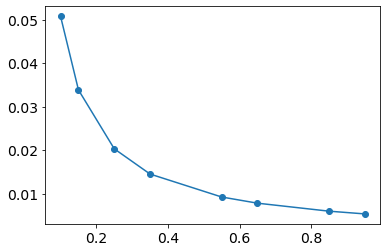

In [148]:
Stimuli = np.zeros(IX.shape,dtype = complex)
Stimuli[::2] = Rs[0,0,-1,IX][::2]
Stimuli[1::2] = Rs[0,0,-2,IX][1::2]

plt.plot(freqs,np.abs(Stimuli),'-o')

In [208]:
R_mean = np.mean(np.abs(Rs[:,cond,:,:][:,:,IX]),axis = 1) #mean across all trials
q25,q50,q75 = np.quantile(R_mean,[0.25,0.5,0.75],axis = 0) # across subjects

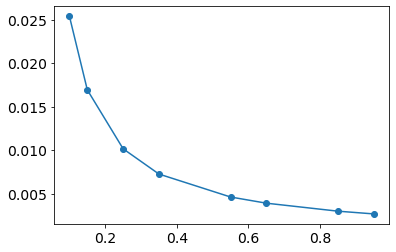

In [209]:
plt.plot(freqs,q50,'-o',label = 'ref r')

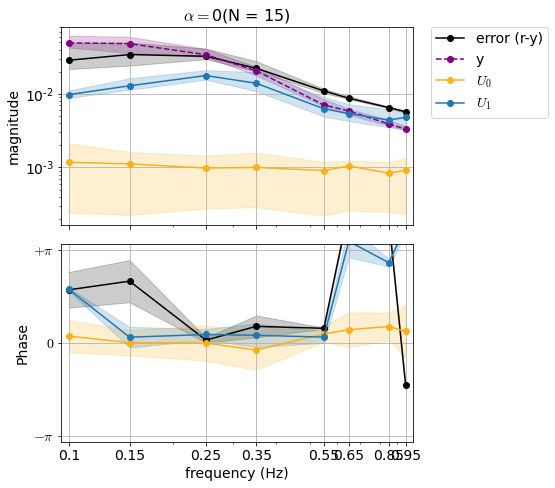

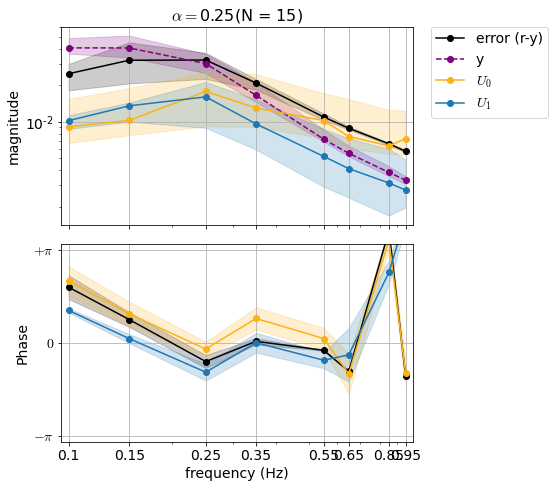

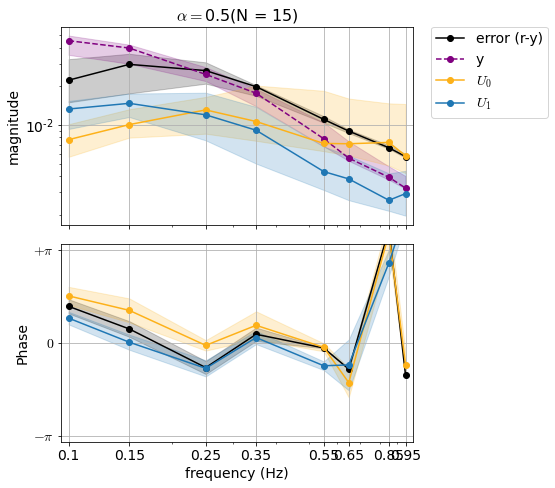

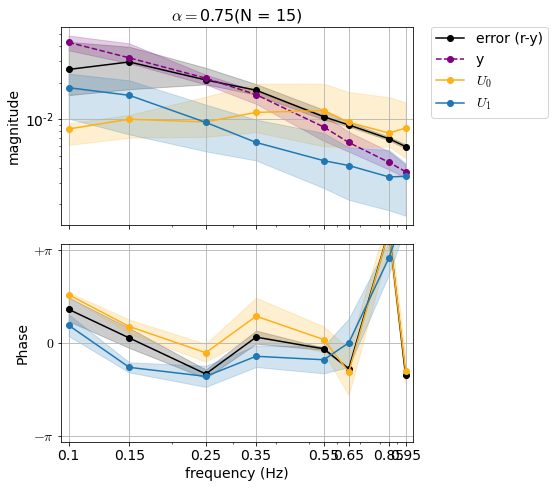

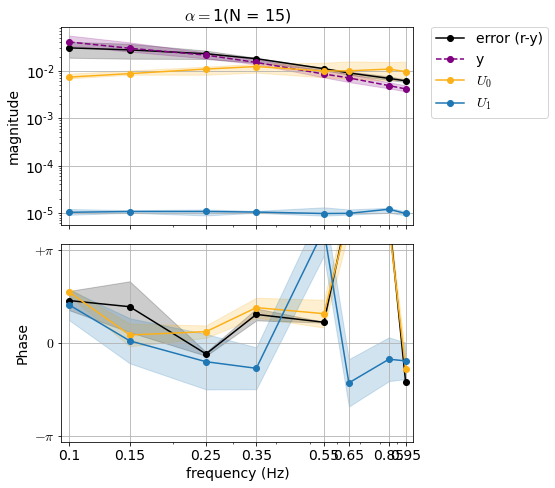

In [280]:
# population level for Even trials
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (-np.pi-0.2,np.pi+ 0.2)
yticksphase = [-np.pi,0.,np.pi]
yticklabelsphase = [r'$-\pi$',r'$0$',r'$+\pi$']

for cond in range(condition_num):
    fig,axs = plt.subplots(2,1,sharex=True,figsize=(8,7))

    # magnitude
    ax = axs[0]
    # # ax.plot(freqs,np.abs(Stimuli),'-o',label = 'ref stimuli',color = 'red')
    # R_mean = np.mean(np.abs(Rs[:,cond,:,:][:,:,IX]),axis = 1) #mean across all trials
    # q25,q50,q75 = np.quantile(R_mean,[0.25,0.5,0.75],axis = 0) # across subjects
    # ax.plot(freqs,q50,'-o',label = 'ref r',color = 'red')
    # ax.fill_between(freqs, q25, q75, alpha=0.2,color = 'red')

    E_mean = np.mean(np.abs(Es[:,cond,:,:][:,:,IX]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(E_mean,[0.25,0.5,0.75],axis = 0) # across subjects
    ax.plot(freqs,q50,'-o',label = 'error (r-y)',color = 'black')
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = 'black')

    mean = np.mean(np.abs(Ys[:,cond,:,:][:,:,IX]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(mean,[0.25,0.5,0.75],axis = 0) # across subjects
    ax.plot(freqs,q50,'--o',label = 'y',color = 'purple')
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = 'purple')

    U0_mean = np.mean(np.abs(U0s[:,cond,:,:][:,:,IX]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(U0_mean,[0.25,0.5,0.75],axis = 0) # across subjects
    ax.plot(freqs,q50,'-o',label = r'$U_0$',color = colors['GOLD'])
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['GOLD'])

    U1_mean = np.mean(np.abs(U1s[:,cond,:,:][:,:,IX]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(U1_mean,[0.25,0.5,0.75],axis = 0) # across subjects
    ax.plot(freqs,q50,'-o',label = r'$U_1$',color = colors['BLUE'])
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['BLUE'])

    ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks,rotation=90) 
    ax.grid('on',zorder=-1)
    # ax.set_ylim(0.1,80)
    ax.set_yscale("log")
    ax.set_ylabel('magnitude')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    # phase
    ax = axs[1]
    # ax.plot(freqs[::2],np.angle(Stimuli)[::2],'-o',label = 'ref stimuli',color = 'red')

    angles = np.angle(np.mean(np.exp(1j*(np.angle(Es[:,cond,:,:][:,:,IX]))),axis = 1))
    z = np.mean(np.exp(1j*(angles-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-o',label = 'error',color = 'black')
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = 'black')

    angles = np.angle(np.mean(np.exp(1j*(np.angle(U0s[:,cond,:,:][:,:,IX]))),axis = 1))
    z = np.mean(np.exp(1j*(angles-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-o',label = 'u0',color = colors['GOLD'])
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GOLD'])

    angles = np.angle(np.mean(np.exp(1j*(np.angle(U1s[:,cond,:,:][:,:,IX]))),axis = 1))
    z = np.mean(np.exp(1j*(angles-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-o',label = 'u1',color = colors['BLUE'])
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['BLUE'])

    ax.set_ylabel('Phase') 
    ax.grid('on',zorder=-1)
    ax.set_ylim(ylimphase)
    ax.set_yticks(yticksphase)
    ax.set_yticklabels(yticklabelsphase)
    ax.set_xlabel('frequency (Hz)')
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    axs[0].set_title(r'$\alpha = $'+conditions[cond]+'(N = 15)')
    plt.tight_layout()
    plt.show()

## interleave stim freqs

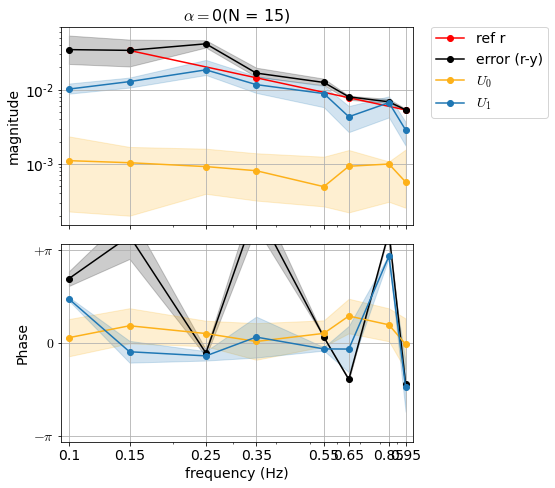

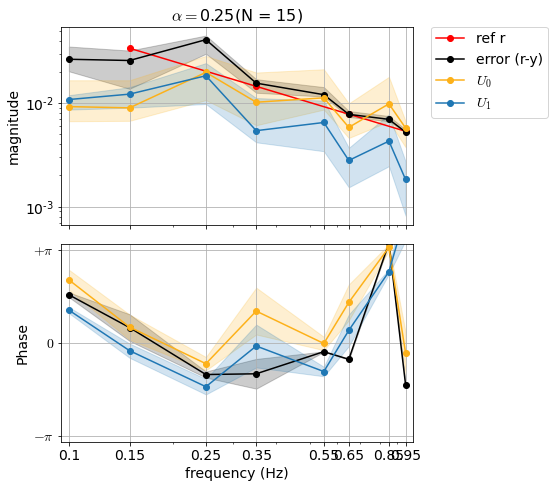

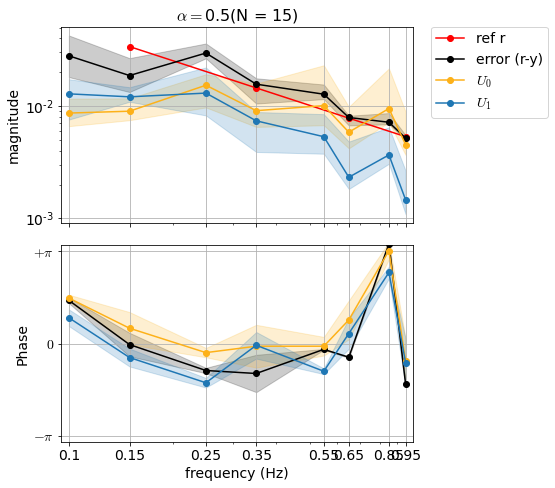

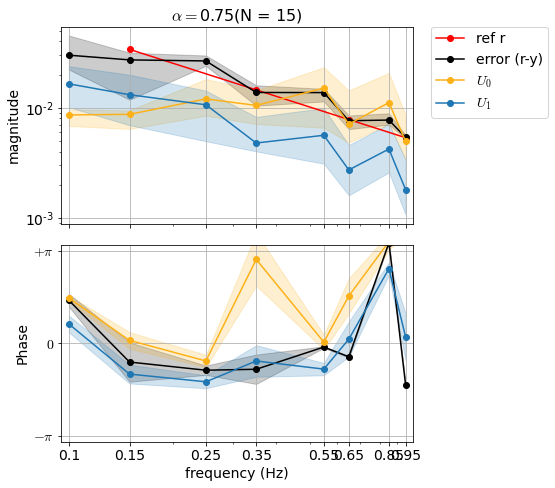

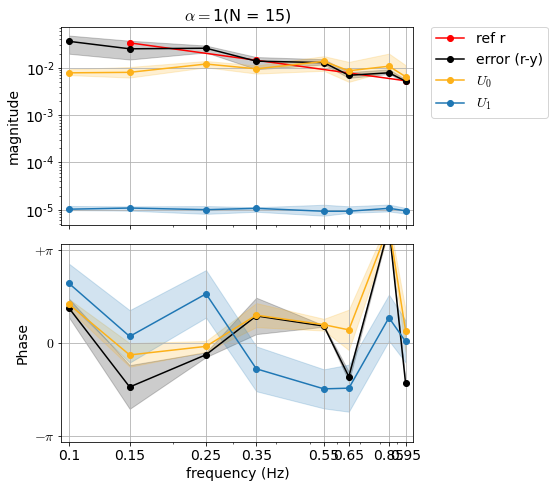

In [216]:
# population level for Even trials
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (-np.pi-0.2,np.pi+ 0.2)
yticksphase = [-np.pi,0.,np.pi]
yticklabelsphase = [r'$-\pi$',r'$0$',r'$+\pi$']

for cond in range(condition_num):
    fig,axs = plt.subplots(2,1,sharex=True,figsize=(8,7))

    # magnitude
    ax = axs[0]
    # ax.plot(freqs,np.abs(Stimuli),'-o',label = 'ref stimuli',color = 'red')
    R_mean = np.mean(np.abs(Rs[:,cond,::2,:][:,:,IX]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(R_mean,[0.25,0.5,0.75],axis = 0) # across subjects
    ax.plot(freqs[1::2],q50[1::2],'-o',label = 'ref r',color = 'red')
    # ax.fill_between(freqs, q25, q75, alpha=0.2,color = 'red')

    E_mean = np.mean(np.abs(Es[:,cond,::2,:][:,:,IX]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(E_mean,[0.25,0.5,0.75],axis = 0) # across subjects
    ax.plot(freqs,q50,'-o',label = 'error (r-y)',color = 'black')
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = 'black')

    # E_mean = np.mean(np.abs(E_ACCs[:,cond,:,:][:,:,IX]),axis = 1) #mean across all trials
    # q25,q50,q75 = np.quantile(E_mean,[0.25,0.5,0.75],axis = 0) # across subjects
    # ax.plot(freqs,q50,'--o',label = 'error acc',color = 'black')
    # ax.fill_between(freqs, q25, q75, alpha=0.2,color = 'black')

    U0_mean = np.mean(np.abs(U0s[:,cond,::2,:][:,:,IX]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(U0_mean,[0.25,0.5,0.75],axis = 0) # across subjects
    ax.plot(freqs,q50,'-o',label = r'$U_0$',color = colors['GOLD'])
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['GOLD'])

    U1_mean = np.mean(np.abs(U1s[:,cond,::2,:][:,:,IX]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(U1_mean,[0.25,0.5,0.75],axis = 0) # across subjects
    ax.plot(freqs,q50,'-o',label = r'$U_1$',color = colors['BLUE'])
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['BLUE'])

    ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks,rotation=90) 
    ax.grid('on',zorder=-1)
    # ax.set_ylim(0.1,80)
    ax.set_yscale("log")
    ax.set_ylabel('magnitude')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    # phase
    ax = axs[1]
    # ax.plot(freqs[::2],np.angle(Stimuli)[::2],'-o',label = 'ref stimuli',color = 'red')

    angles = np.angle(np.mean(np.exp(1j*(np.angle(Es[:,cond,::2,:][:,:,IX]))),axis = 1))
    z = np.mean(np.exp(1j*(angles-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-o',label = 'error',color = 'black')
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = 'black')

    angles = np.angle(np.mean(np.exp(1j*(np.angle(U0s[:,cond,::2,:][:,:,IX]))),axis = 1))
    z = np.mean(np.exp(1j*(angles-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-o',label = 'u0',color = colors['GOLD'])
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GOLD'])

    angles = np.angle(np.mean(np.exp(1j*(np.angle(U1s[:,cond,::2,:][:,:,IX]))),axis = 1))
    z = np.mean(np.exp(1j*(angles-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-o',label = 'u1',color = colors['BLUE'])
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['BLUE'])

    ax.set_ylabel('Phase') 
    ax.grid('on',zorder=-1)
    ax.set_ylim(ylimphase)
    ax.set_yticks(yticksphase)
    ax.set_yticklabels(yticklabelsphase)
    ax.set_xlabel('frequency (Hz)')
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    axs[0].set_title(r'$\alpha = $'+conditions[cond]+'(N = 15)')
    plt.tight_layout()
    plt.show()

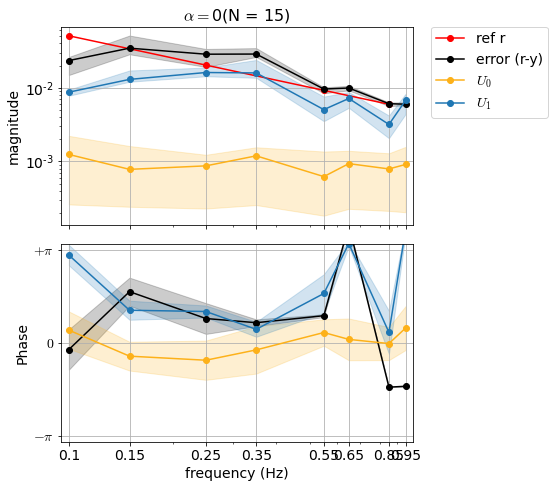

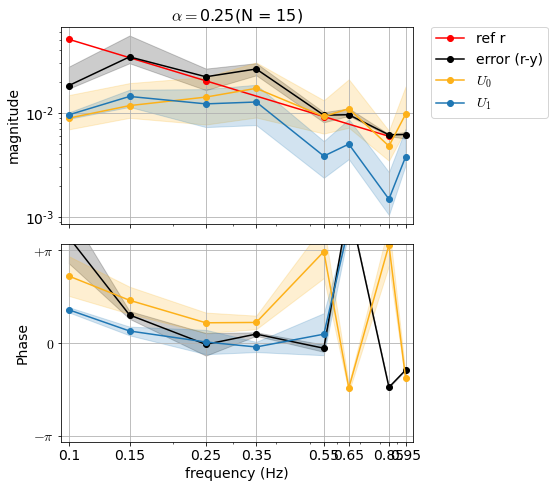

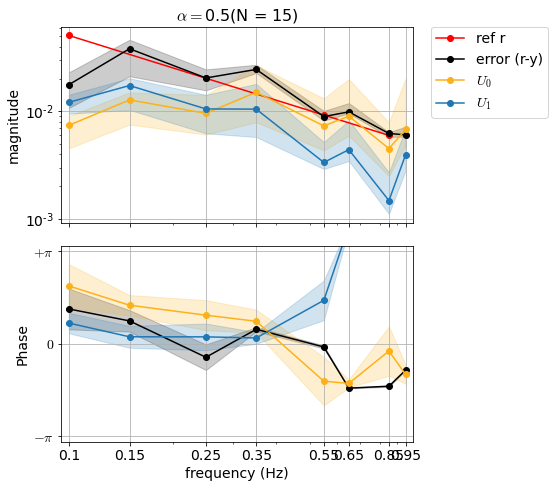

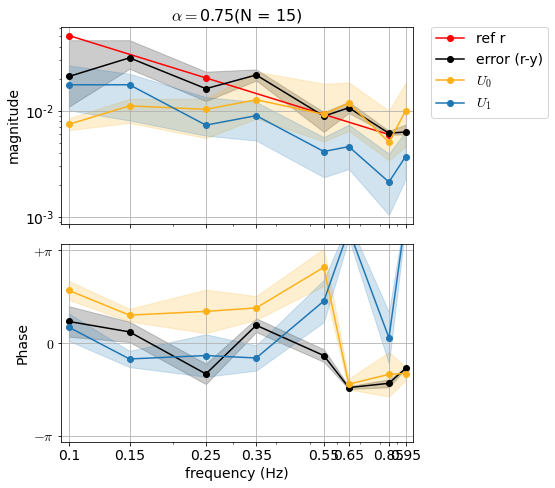

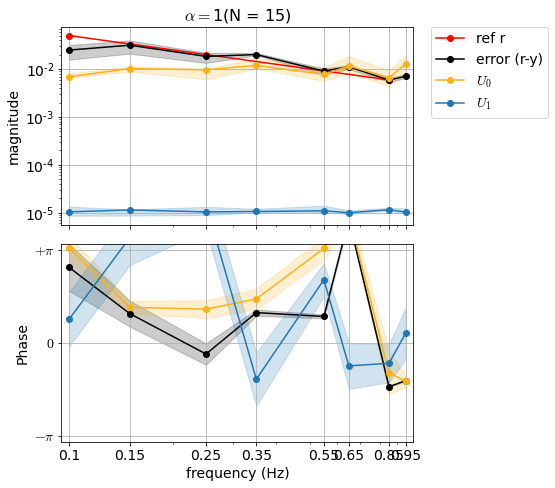

In [215]:
# population level for Even trials
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (-np.pi-0.2,np.pi+ 0.2)
yticksphase = [-np.pi,0.,np.pi]
yticklabelsphase = [r'$-\pi$',r'$0$',r'$+\pi$']

for cond in range(condition_num):
    fig,axs = plt.subplots(2,1,sharex=True,figsize=(8,7))

    # magnitude
    ax = axs[0]
    # ax.plot(freqs,np.abs(Stimuli),'-o',label = 'ref stimuli',color = 'red')
    R_mean = np.mean(np.abs(Rs[:,cond,1::2,:][:,:,IX]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(R_mean,[0.25,0.5,0.75],axis = 0) # across subjects
    ax.plot(freqs[::2],q50[::2],'-o',label = 'ref r',color = 'red')
    # ax.fill_between(freqs, q25, q75, alpha=0.2,color = 'red')

    E_mean = np.mean(np.abs(Es[:,cond,1::2,:][:,:,IX]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(E_mean,[0.25,0.5,0.75],axis = 0) # across subjects
    ax.plot(freqs,q50,'-o',label = 'error (r-y)',color = 'black')
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = 'black')

    # E_mean = np.mean(np.abs(E_ACCs[:,cond,:,:][:,:,IX]),axis = 1) #mean across all trials
    # q25,q50,q75 = np.quantile(E_mean,[0.25,0.5,0.75],axis = 0) # across subjects
    # ax.plot(freqs,q50,'--o',label = 'error acc',color = 'black')
    # ax.fill_between(freqs, q25, q75, alpha=0.2,color = 'black')

    U0_mean = np.mean(np.abs(U0s[:,cond,1::2,:][:,:,IX]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(U0_mean,[0.25,0.5,0.75],axis = 0) # across subjects
    ax.plot(freqs,q50,'-o',label = r'$U_0$',color = colors['GOLD'])
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['GOLD'])

    U1_mean = np.mean(np.abs(U1s[:,cond,1::2,:][:,:,IX]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(U1_mean,[0.25,0.5,0.75],axis = 0) # across subjects
    ax.plot(freqs,q50,'-o',label = r'$U_1$',color = colors['BLUE'])
    ax.fill_between(freqs, q25, q75, alpha=0.2,color = colors['BLUE'])

    ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks,rotation=90) 
    ax.grid('on',zorder=-1)
    # ax.set_ylim(0.1,80)
    ax.set_yscale("log")
    ax.set_ylabel('magnitude')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    # phase
    ax = axs[1]
    # ax.plot(freqs[::2],np.angle(Stimuli)[::2],'-o',label = 'ref stimuli',color = 'red')

    angles = np.angle(np.mean(np.exp(1j*(np.angle(Es[:,cond,1::2,:][:,:,IX]))),axis = 1))
    z = np.mean(np.exp(1j*(angles-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-o',label = 'error',color = 'black')
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = 'black')

    angles = np.angle(np.mean(np.exp(1j*(np.angle(U0s[:,cond,1::2,:][:,:,IX]))),axis = 1))
    z = np.mean(np.exp(1j*(angles-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-o',label = 'u0',color = colors['GOLD'])
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GOLD'])

    angles = np.angle(np.mean(np.exp(1j*(np.angle(U1s[:,cond,1::2,:][:,:,IX]))),axis = 1))
    z = np.mean(np.exp(1j*(angles-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-o',label = 'u1',color = colors['BLUE'])
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['BLUE'])

    ax.set_ylabel('Phase') 
    ax.grid('on',zorder=-1)
    ax.set_ylim(ylimphase)
    ax.set_yticks(yticksphase)
    ax.set_yticklabels(yticklabelsphase)
    ax.set_xlabel('frequency (Hz)')
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    axs[0].set_title(r'$\alpha = $'+conditions[cond]+'(N = 15)')
    plt.tight_layout()
    plt.show()

## all freq

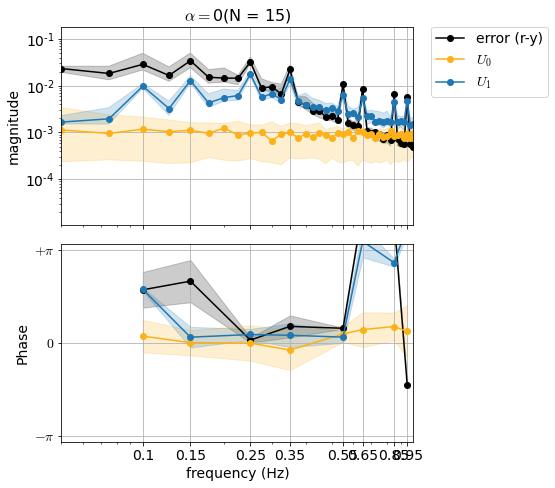

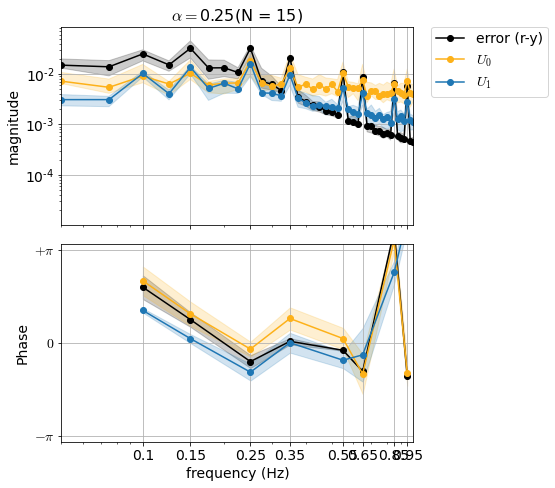

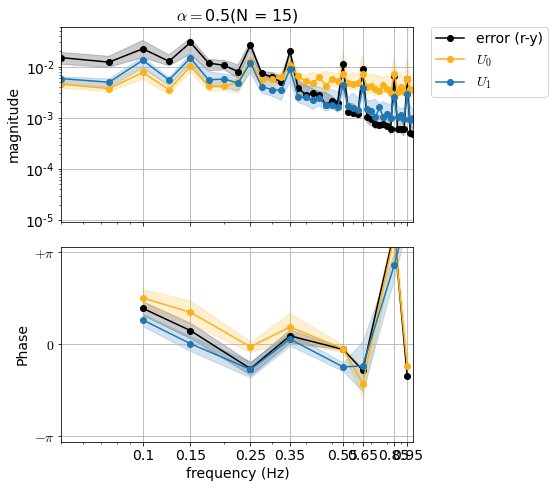

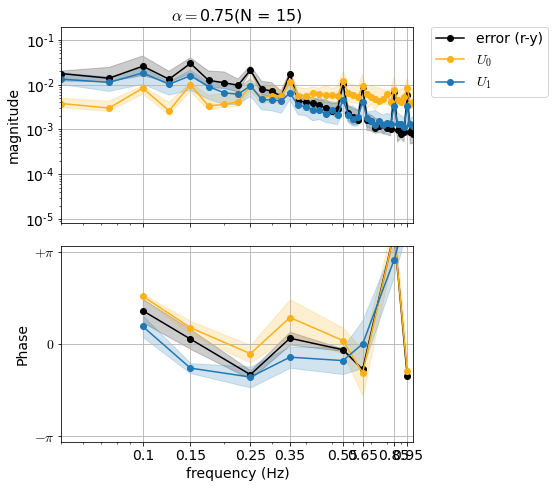

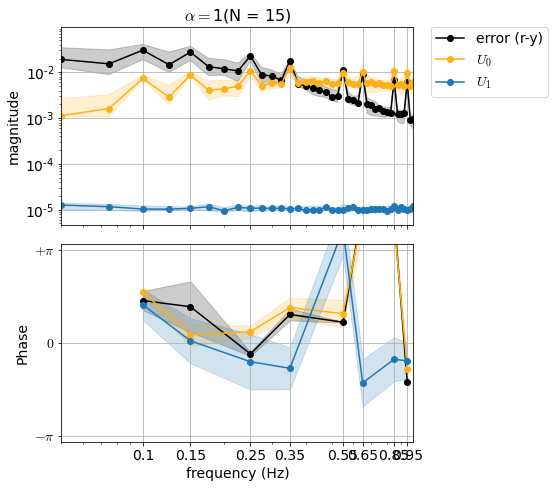

In [207]:
# population level 
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.05, 1.0)
ylimphase = (-np.pi-0.2,np.pi+ 0.2)
yticksphase = [-np.pi,0.,np.pi]
yticklabelsphase = [r'$-\pi$',r'$0$',r'$+\pi$']

for cond in range(condition_num):
    fig,axs = plt.subplots(2,1,sharex=True,figsize=(8,7))

    # magnitude
    ax = axs[0]
    E_mean = np.mean(np.abs(Es[:,cond,:,:][:,:,:N//2]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(E_mean,[0.25,0.5,0.75],axis = 0) # across subjects
    ax.plot(xf,q50,'-o',label = 'error (r-y)',color = 'black')
    ax.fill_between(xf, q25, q75, alpha=0.2,color = 'black')

    U0_mean = np.mean(np.abs(U0s[:,cond,:,:][:,:,:N//2]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(U0_mean,[0.25,0.5,0.75],axis = 0) # across subjects
    ax.plot(xf,q50,'-o',label = r'$U_0$',color = colors['GOLD'])
    ax.fill_between(xf, q25, q75, alpha=0.2,color = colors['GOLD'])

    U1_mean = np.mean(np.abs(U1s[:,cond,:,:][:,:,:N//2]),axis = 1) #mean across all trials
    q25,q50,q75 = np.quantile(U1_mean,[0.25,0.5,0.75],axis = 0) # across subjects
    ax.plot(xf,q50,'-o',label = r'$U_1$',color = colors['BLUE'])
    ax.fill_between(xf, q25, q75, alpha=0.2,color = colors['BLUE'])

    ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks,rotation=90) 
    ax.grid('on',zorder=-1)
    # ax.set_ylim(0.1,80)
    ax.set_yscale("log")
    ax.set_ylabel('magnitude')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    # phase
    ax = axs[1]
    angles = np.angle(np.mean(np.exp(1j*(np.angle(Es[:,cond,:,:][:,:,IX]))),axis = 1))
    z = np.mean(np.exp(1j*(angles-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-o',label = 'error',color = 'black')
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = 'black')

    angles = np.angle(np.mean(np.exp(1j*(np.angle(U0s[:,cond,:,:][:,:,IX]))),axis = 1))
    z = np.mean(np.exp(1j*(angles-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-o',label = 'u0',color = colors['GOLD'])
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GOLD'])

    angles = np.angle(np.mean(np.exp(1j*(np.angle(U1s[:,cond,:,:][:,:,IX]))),axis = 1))
    z = np.mean(np.exp(1j*(angles-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-o',label = 'u1',color = colors['BLUE'])
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['BLUE'])

    ax.set_ylabel('Phase') 
    ax.grid('on',zorder=-1)
    ax.set_ylim(ylimphase)
    ax.set_yticks(yticksphase)
    ax.set_yticklabels(yticklabelsphase)
    ax.set_xlabel('frequency (Hz)')
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    axs[0].set_title(r'$\alpha = $'+conditions[cond]+'(N = 15)')
    plt.tight_layout()
    plt.show()

## inputs to the ref, at ref stimuli

In [ ]:
cond = 0
R_mean = np.mean(np.abs(Rs[:,cond,::2,:][:,:,IX]),axis = 1) #mean across all trials
# q25,q50,q75 = np.quantile(R_mean,[0.25,0.5,0.75],axis = 0) # across subjects
R_mean.shape

(15, 8)

In [232]:
def interquartile_interleave(DATA,cond):   # at ref stimuli at interleaved trials
    q25s = np.zeros(IX.shape[0])
    q50s = np.zeros(IX.shape[0])
    q75s = np.zeros(IX.shape[0])
    mean = np.mean(np.abs(DATA[:,cond,::2,:][:,:,IX]),axis = 1) #mean across even trials
    q25,q50,q75 = np.quantile(mean,[0.25,0.5,0.75],axis = 0) # across subjects
    q25s[1::2] = q25[1::2]
    q50s[1::2] = q50[1::2]
    q75s[1::2] = q75[1::2]

    mean = np.mean(np.abs(DATA[:,cond,1::2,:][:,:,IX]),axis = 1) #mean across odd trials
    q25,q50,q75 = np.quantile(mean,[0.25,0.5,0.75],axis = 0) # across subjects
    q25s[::2] = q25[::2]
    q50s[::2] = q50[::2]
    q75s[::2] = q75[::2]

    return q25s,q50s,q75s

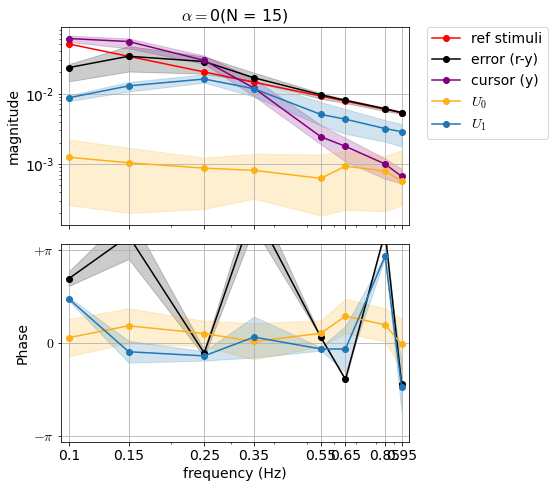

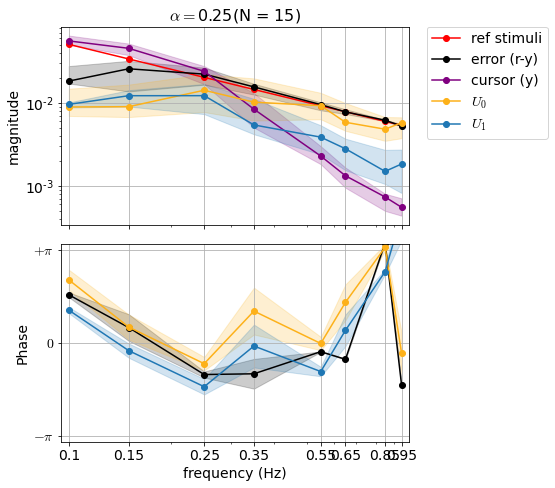

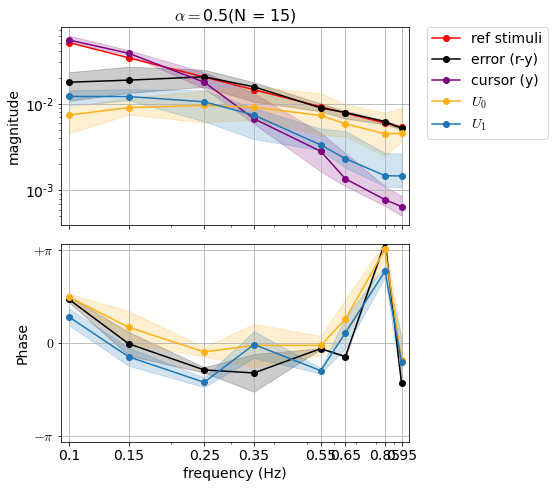

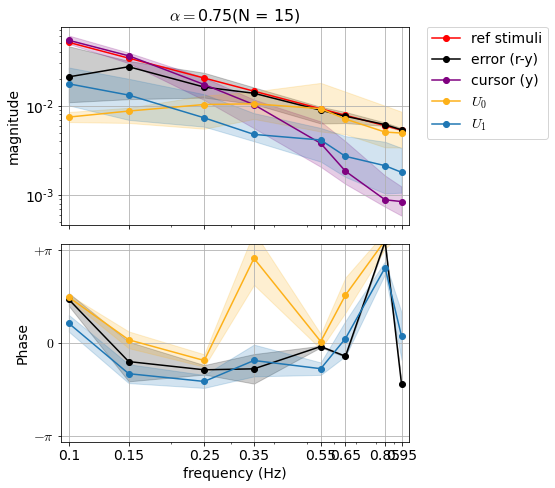

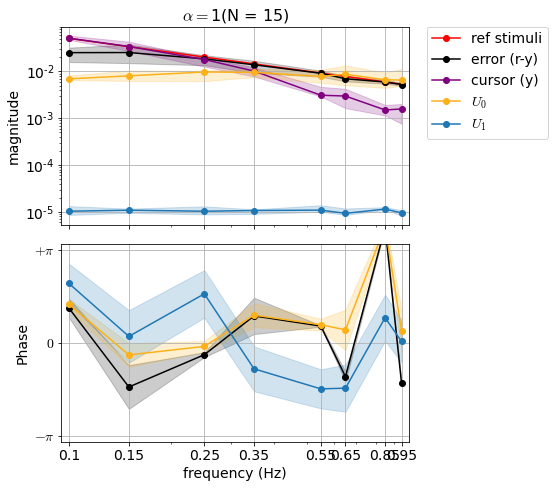

In [251]:
# population level for Even trials
# Bode plot of F and B
xticks = np.array([0.1 , 0.15, 0.25, 0.35, 0.55, 0.65, 0.85, 0.95])
xlim = (0.095, 1.0)
ylimphase = (-np.pi-0.2,np.pi+ 0.2)
yticksphase = [-np.pi,0.,np.pi]
yticklabelsphase = [r'$-\pi$',r'$0$',r'$+\pi$']

for cond in range(condition_num):
    # cond  = 2
    fig,axs = plt.subplots(2,1,sharex=True,figsize=(8,7))

    # magnitude
    ax = axs[0]
    ax.plot(freqs,np.abs(Stimuli),'-o',label = 'ref stimuli',color = 'red')

    q25s,q50s,q75s = interquartile_interleave(Es,cond)
    ax.plot(freqs,q50s,'-o',label = 'error (r-y)',color = 'black')
    ax.fill_between(freqs, q25s, q75s, alpha=0.2,color = 'black')

    q25s,q50s,q75s = interquartile_interleave(Ys,cond)
    ax.plot(freqs,q50s,'-o',label = 'cursor (y)',color = 'purple')
    ax.fill_between(freqs, q25s, q75s, alpha=0.2,color = 'purple')

    q25s,q50s,q75s = interquartile_interleave(U0s,cond)
    ax.plot(freqs,q50s,'-o',label = r'$U_0$',color = colors['GOLD'])
    ax.fill_between(freqs, q25s, q75s, alpha=0.2,color = colors['GOLD'])

    q25s,q50s,q75s = interquartile_interleave(U1s,cond)
    ax.plot(freqs,q50s,'-o',label = r'$U_1$',color = colors['BLUE'])
    ax.fill_between(freqs, q25s, q75s, alpha=0.2,color = colors['BLUE'])

    ax.set_xscale("log")
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks,rotation=90) 
    ax.grid('on',zorder=-1)
    # ax.set_ylim(0.1,80)
    ax.set_yscale("log")
    ax.set_ylabel('magnitude')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    # phase
    ax = axs[1]
    # ax.plot(freqs[::2],np.angle(Stimuli)[::2],'-o',label = 'ref stimuli',color = 'red')

    angles = np.angle(np.mean(np.exp(1j*(np.angle(Es[:,cond,::2,:][:,:,IX]))),axis = 1))
    z = np.mean(np.exp(1j*(angles-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-o',label = 'error',color = 'black')
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = 'black')

    angles = np.angle(np.mean(np.exp(1j*(np.angle(U0s[:,cond,::2,:][:,:,IX]))),axis = 1))
    z = np.mean(np.exp(1j*(angles-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-o',label = 'u0',color = colors['GOLD'])
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['GOLD'])

    angles = np.angle(np.mean(np.exp(1j*(np.angle(U1s[:,cond,::2,:][:,:,IX]))),axis = 1))
    z = np.mean(np.exp(1j*(angles-np.pi/2)), axis=0)
    mean = np.angle(z)+np.pi/2
    disp = 1 - np.abs(z)
    ax.plot(freqs,mean,'-o',label = 'u1',color = colors['BLUE'])
    ax.fill_between(freqs,mean+disp,mean-disp,alpha = 0.2,color = colors['BLUE'])

    ax.set_ylabel('Phase') 
    ax.grid('on',zorder=-1)
    ax.set_ylim(ylimphase)
    ax.set_yticks(yticksphase)
    ax.set_yticklabels(yticklabelsphase)
    ax.set_xlabel('frequency (Hz)')
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    axs[0].set_title(r'$\alpha = $'+conditions[cond]+'(N = 15)')
    plt.tight_layout()
    plt.show()